In [1]:
import bioframe as bf
import gpn.model
from gpn.data import load_table, Genome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from umap import UMAP
import umap
import umap.plot

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default

In [2]:
MODEL = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"
d = Path("../../results/embedding")
windows = pd.read_parquet(d / "windows.parquet")
windows.loc[:, ["UMAP1", "UMAP2"]] = pd.read_parquet(d / "umap" / f"{MODEL}.parquet").values
windows

,chrom,start,end,strand,center_start,center_end,Region,UMAP1,UMAP2
0,8,22104645,22104773,+,22104659,22104759,three_prime_utr,-0.640508,-2.403165
1,6,43017800,43017928,+,43017814,43017914,intron,-0.289261,11.298820
2,10,132228030,132228158,+,132228044,132228144,CDS,0.956435,13.319980
3,2,233802186,233802314,+,233802200,233802300,CDS,-0.954063,11.619383
4,11,108158364,108158492,+,108158378,108158478,three_prime_utr,2.708754,6.029018
...,...,...,...,...,...,...,...,...,...
107599,3,20038083,20038211,+,20038097,20038197,intergenic,2.313986,6.970305
107600,5,75583607,75583735,+,75583621,75583721,intron,2.170003,0.713604
107601,14,70032013,70032141,+,70032027,70032127,three_prime_utr,-1.587923,-0.944793
107602,20,63312819,63312947,+,63312833,63312933,CDS,0.219461,11.676358


In [3]:
windows.Region = windows.Region.replace({
    "intergenic": "Intergenic",
    "intron": "Intron",
    "five_prime_utr": "5' UTR",
    "three_prime_utr": "3' UTR",
})

In [9]:
windows.Region.value_counts()

Region
3' UTR        17934
Intron        17934
CDS           17934
Repeat        17934
5' UTR        17934
Intergenic    17934
Name: count, dtype: int64

In [4]:
mapper = UMAP()
mapper.embedding_ = windows[["UMAP1", "UMAP2"]].values

In [5]:
def get_color_key(classes, palette):
    color_palette = sns.color_palette(palette, n_colors=len(classes)).as_hex()
    return {c: color_palette[i] for i, c in enumerate(classes)}

def umap_plot_labels(labels, title, label_order, cmap="tab10", save_to=None, **kwargs):
    g = umap.plot.points(
        mapper,
        labels=labels,
        subset_points=labels.isin(label_order),
        color_key=get_color_key(label_order, cmap),
        **kwargs,
    );
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
    g.legend_.set_title(title);
    sns.despine();
    for txt in g.texts:
        txt.set_visible(False)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")

In [6]:
#plt.rcParams["figure.dpi"] = 200  # need to play with both this and height,width

In [7]:
# avoid having both green and red
#color_palette = np.array(sns.color_palette("tab10"))[[0,1,9,3,4,5,6]]
color_palette = "tab10"

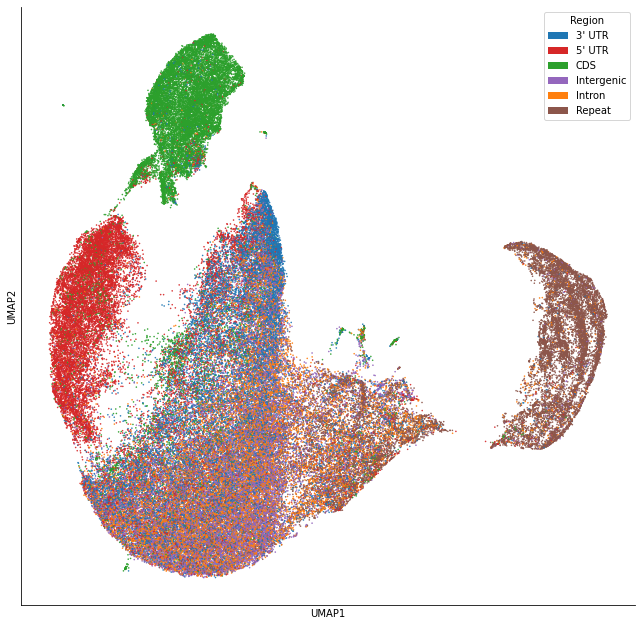

In [8]:
regions = windows.Region.value_counts().index.values

# Make sure Repeat goes last
if "Repeat" in regions:
    regions = regions[regions!="Repeat"].tolist() + ["Repeat"]

    
umap_plot_labels(
    windows.Region, "Region", regions, cmap=color_palette,
    height=1100, width=1100, 
    #height=900, width=900, 
    #save_to="output/plots/umap.pdf",
    #save_to="output/plots/umap_kmers_5.svg",
)

In [ ]:
# maybe set up a simple classification task with sklearn?